In [1]:
# Necessary imports for this notebook
import os

import numpy as np
import pandas as pd
import datetime
import time
import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Import Unsupervised ML algorithms libraries
from pyod.models.knn import KNN          # K nearest Neighbour
from pyod.models.lof import LOF          # Local Outilier Factor
from pyod.models.pca import PCA          # Principal Component Analysis
from pyod.models.iforest import IForest  # Isolation Forest

import ray
import mlflow
import pickle

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
pd.set_option('max_colwidth', None)


In [2]:
# Initialize Ray
#if ray.is_initialized():
#    ray.shutdown()
#ray.init(num_cpus = 8, num_gpus=0, resources = {"special_hardware":1, "custom_label":1})

# 1. Load Data

In [3]:
# Load a set of pickle files, put them together in a single DataFrame, and order them by time
# It takes as input the folder DIR_INPUT where the files are stored, and the BEGIN_DATE and END_DATE
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace(-1,0)
    
    return df_final

In [4]:
DIR_INPUT='./simulated-data-raw-ccfd/' 

BEGIN_DATE = "2021-04-01"
END_DATE = "2021-09-30"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 623 ms, sys: 176 ms, total: 799 ms
Wall time: 1.01 s
1754155 transactions loaded, containing 14681 fraudulent transactions


In [5]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2021-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2021-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2021-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2021-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2021-04-01 00:10:34,927,9906,50.99,634,0,0,0


# 2. EDA

In [6]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB


Observations:
- no missing values in the data,
- the data columns data type are a mix of categorical and numerical features.
-  We need to convert the `TX_DATETIME` to a datetime data type

In [7]:
# Convert 'TX_DATETIME' column to datetime format
transactions_df['TX_DATETIME'] = pd.to_datetime(transactions_df['TX_DATETIME'])

In [8]:
transactions_df['TX_DATETIME'].dtype

dtype('<M8[ns]')

In [9]:
transactions_df.shape

(1754155, 9)

- check for duplicates

In [10]:
#check data for duplicates
duplicates = transactions_df[transactions_df.duplicated()]
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 0


- Percentage of fraudulent transactions

In [11]:
p = transactions_df.TX_FRAUD.mean()
print(f"Percentage of fraudulent transactions: {p*100:.4f} %")

Percentage of fraudulent transactions: 0.8369 %


- Number of fraudulent transactions:

In [12]:
n = transactions_df.TX_FRAUD.sum()
print(f"Number of fraudulent transactions: {n}")

Number of fraudulent transactions: 14681


- visualize the distribturion of some features

In [13]:
from collections import Counter

# Most common tags
all_tags = Counter(transactions_df['TX_FRAUD'])
all_tags.most_common()

[(0, 1739474), (1, 14681)]

We can then separate the tags and from their respective counts and plot them using

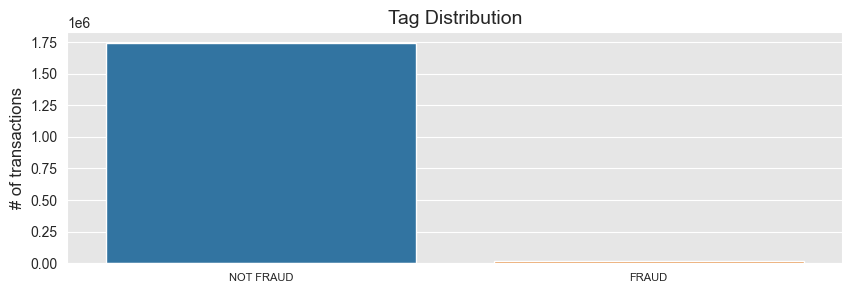

In [14]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
tags = ['NOT FRAUD', 'FRAUD']
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts),)
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag Distribution", fontsize=14)
plt.ylabel("# of transactions", fontsize=12)
plt.show()


In [15]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=1000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=1000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True,kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

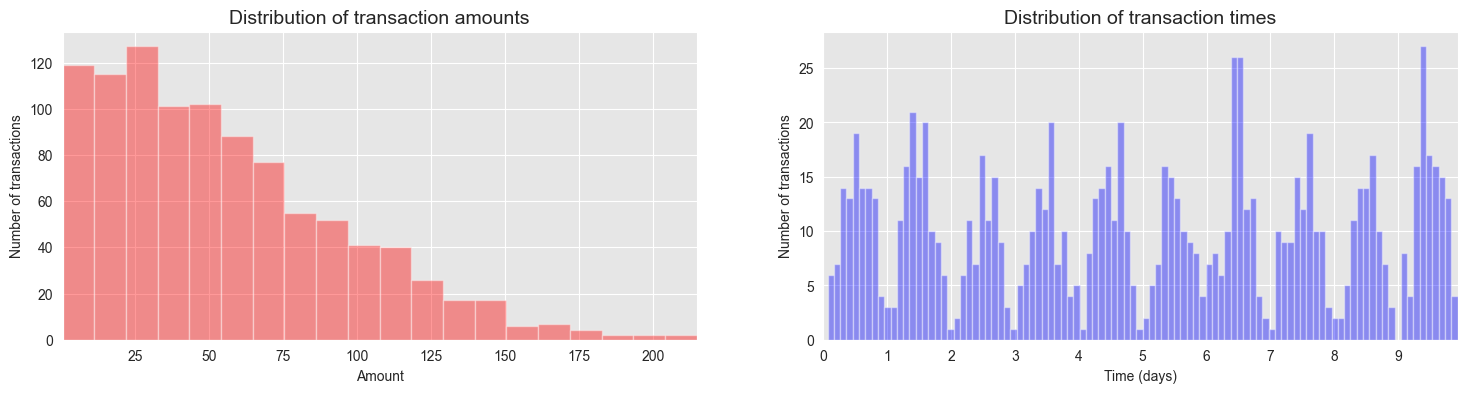

In [16]:
distribution_amount_times_fig

# 3. Feature Engineering

ML algorithms typically require numerical and ordered features as inputs. Thus, since our data comprises non-numrical and categorical features, we have to deal with them. For this project, We'd design new features that are assumed to be relevant for credit card fraud detection using the following methods:

- One-hot encoding
- RFM (Recency, Frequncy, Monetary value)
- Frequency (or Risk) Encoding

## 3.1 Date and Time Transformation

Here, we design two features:
- First, we'd want to characterise a transaction whether occured during a weekday (0) or a weekend (1). This engineered feature will be called `TX_DURING_WEEKEND`
- Second, we'd want to characterise a transaction whether occured during the day (0) or at night (1). This engineered feature will be called `TX_DURING_NIGHT`. Transactions are considered as night if the transaction occured between 0pm and 6am,  otherwise day.

In [17]:
# Function to transform transaction datetime to weekday or weekend
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

- compute `TX_DURING_WEEKEND` feature

In [18]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: user 1.66 s, sys: 51.5 ms, total: 1.71 s
Wall time: 1.71 s


In [19]:
# Function to transform transaction datetime to night or day 
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

- compute `TX_DURING_NIGHT` feature

In [20]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: user 1.49 s, sys: 46.8 ms, total: 1.54 s
Wall time: 1.54 s


- Test to see if the new coumns were correctly computed

In [21]:
transactions_df[transactions_df.TX_TIME_DAYS>=90].head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT
863006,863006,2021-06-30 00:00:26,1958,5160,120.20,7776026,90,0,0,0,1
863007,863007,2021-06-30 00:01:06,3300,7921,16.93,7776066,90,0,0,0,1
863008,863008,2021-06-30 00:02:57,2707,2630,58.73,7776177,90,0,0,0,1
863009,863009,2021-06-30 00:04:07,1186,9265,54.23,7776247,90,0,0,0,1
863010,863010,2021-06-30 00:04:52,3781,1038,83.74,7776292,90,0,0,0,1


## 3.2 Customer ID transformations

In this case, we'd use the RFM (Recency, Frequency, Monetary Value) method, to compute two of the features over three time windows.

- First feature is **the number of transaction that occurs within a time window (Frequency)**
- Second feature is **the average amount spent in these transactions (Monetary Value)**

The time windows will be set to 1 day, 7 days, and 30 days. Hence, our transfformation will generate six additional features. The `get_customer_spending_behaviour_features` will be used to compute these features

In [22]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

- As an example, compute the aggregates for the first customer

In [23]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,
1758,1758,2021-04-01 07:19:05,0,6076,123.59,26345,0,0,0,0,0,1.0,123.590000,1.0,123.590000,1.0,123.590000
8275,8275,2021-04-01 18:00:16,0,858,77.34,64816,0,0,0,0,0,2.0,100.465000,2.0,100.465000,2.0,100.465000
8640,8640,2021-04-01 19:02:02,0,6698,46.51,68522,0,0,0,0,0,3.0,82.480000,3.0,82.480000,3.0,82.480000
12169,12169,2021-04-02 08:51:06,0,6569,54.72,118266,1,0,0,0,0,3.0,59.523333,4.0,75.540000,4.0,75.540000
15764,15764,2021-04-02 14:05:38,0,7707,63.30,137138,1,0,0,0,0,4.0,60.467500,5.0,73.092000,5.0,73.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1750390,1750390,2021-09-30 13:38:41,0,3096,38.23,15773921,182,0,0,0,0,5.0,64.388000,28.0,57.306429,89.0,63.097640
1750758,1750758,2021-09-30 14:10:21,0,9441,43.60,15775821,182,0,0,0,0,6.0,60.923333,29.0,56.833793,89.0,62.433933
1751039,1751039,2021-09-30 14:34:30,0,1138,69.69,15777270,182,0,0,0,0,7.0,62.175714,29.0,57.872414,90.0,62.514556


- Now generate features for all customers

In [24]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 9.6 s, sys: 189 ms, total: 9.79 s
Wall time: 9.81 s


In [25]:
transactions_df.shape

(1754155, 17)

## 3.3 Terminal ID transformations

In this case, the goal will be to extract a *risk* score. This assesses the exposure of a given terminal ID to fradulent transactions.

The risk score will be defined as **the average number of fraudulaent transactions that occured on a terminal ID over a time window**

`get_count_risk_rolling_window function` takes as inputs the DataFrame of transactions for a given terminal ID, the delay period, and a list of window sizes. In the first stage, the number of transactions and fraudulent transactions are computed for the delay period (NB_TX_DELAY and NB_FRAUD_DELAY). In the second stage, the number of transactions and fraudulent transactions are computed for each window size plus the delay period (NB_TX_DELAY_WINDOW and NB_FRAUD_DELAY_WINDOW). The number of transactions and fraudulent transactions that occurred for a given window size, shifted back by the delay period, is then obtained by simply computing the differences of the quantities obtained for the delay period, and the window size plus delay period:

NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY

NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY

To a first approximation, this delay period will be set to one week. The risk score is finally obtained by computing the proportion of fraudulent transactions for each window size (or 0 if no transaction occurred for the given window):

RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW

In [26]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [27]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 21.4 s, sys: 527 ms, total: 21.9 s
Wall time: 22.1 s


In [28]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2021-04-01 00:00:31,596,3156,57.16,31,0,0,0,0,...,1.0,57.16,1.0,57.16,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-01 00:02:10,4961,3412,81.51,130,0,0,0,0,...,1.0,81.51,1.0,81.51,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-01 00:07:56,2,1365,146.00,476,0,0,0,0,...,1.0,146.00,1.0,146.00,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-01 00:09:29,4128,8737,64.49,569,0,0,0,0,...,1.0,64.49,1.0,64.49,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-01 00:10:34,927,9906,50.99,634,0,0,0,0,...,1.0,50.99,1.0,50.99,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Model Training

## 4.1 Split data into train and test set

In [29]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

- To reduce computation load, we can use a sample of the data. For example, we could use 14 days transactions from 2021-06-14 to the 2021-06-27 for the training set, and from the 2021-07-05 to the 2021-07-11 (7 days) for the test set. The test data is taken just 7 days after the training data to account for the delay period.

In [30]:
# Define the start date for train data
train_start_date = datetime.datetime.strptime("2021-06-14", "%Y-%m-%d")
filtered_train, filtered_test=get_train_test_set(transactions_df,train_start_date,
                                       delta_train=14,delta_delay=7,delta_test=7)

In [31]:
filtered_train.shape

(134141, 23)

In [32]:
filtered_train[filtered_train.TX_FRAUD==1].shape

(1196, 23)

In [33]:
filtered_test.shape

(53062, 23)

In [34]:
filtered_test[filtered_test.TX_FRAUD==1].shape

(358, 23)

In [35]:
1185/134189

0.008830828160281395

- The train set contains 134189 transactions, among which 1185 are fraudulent. That is about 0.88% fraudulent transactions. Thus, the class balance for non-fraudulent and fraudulent transactions is preserved.
- Next, we define the output and input features for our model.

In [36]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

In [37]:
X_train = filtered_train[input_features]
y_train = filtered_train[output_feature]

X_test = filtered_test[input_features]
y_test = filtered_test[output_feature]

## 4.2 Train Baseline Model using Unsupervised pyOD anomaly detectors

In [38]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

def train_model(model,train,test):
    
    # Create a pipeline with scaling and model instance
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])
        
    
    # Train model
    start_time=time.time()
    pipeline.fit(train) # -----> unsupervised training model
    training_execution_time= round(time.time()-start_time,4)

    # Predict anomalies on the test set
    start_time=time.time()
    predictions_test= pipeline.predict_proba(test, method = 'linear')[:,1] # probability of outlier [:,1] & normal [:,0]
    prediction_execution_time= round(time.time()-start_time,4)

    predictions_train = pipeline.predict_proba(train, method = 'linear')[:,1]
    

    # store results 
    model_and_predictions_dictionary = {'model': pipeline,
                                    'predictions_test': predictions_test,
                                    'predictions_train': predictions_train,
                                    'training_execution_time': training_execution_time,
                                    'prediction_execution_time': prediction_execution_time
                                   }
    print(f"Model Training... Done!")
    return model_and_predictions_dictionary 
    

In [39]:
# train an Isolation Forest classifier
model = IForest()
model_and_predictions_dictionary = train_model(model, X_train.values, X_test.values)

Model Training... Done!


- Let's take a look at the predictions for the first five transactions of the test data

In [40]:
filtered_test['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
filtered_test.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
911319,911319,2021-07-05 00:01:07,2965,4210,10.29,8208067,95,0,0,0,...,57.173750,91.0,57.401538,1.0,0.0,7.0,0.0,32.0,0.0,0.210105
911320,911320,2021-07-05 00:01:14,738,4762,6.57,8208074,95,0,0,0,...,9.228824,65.0,9.412769,1.0,0.0,7.0,0.0,26.0,0.0,0.295509
911322,911322,2021-07-05 00:02:20,147,6044,79.77,8208140,95,0,0,0,...,77.242632,92.0,69.383696,1.0,0.0,4.0,0.0,33.0,0.0,0.243443
911323,911323,2021-07-05 00:03:22,4510,1692,85.68,8208202,95,0,0,0,...,50.376316,63.0,55.936032,0.0,0.0,5.0,0.0,21.0,0.0,0.294186
911324,911324,2021-07-05 00:03:22,1954,8176,13.13,8208202,95,0,0,0,...,20.190000,61.0,24.028033,0.0,0.0,5.0,0.0,35.0,0.0,0.268726


## 4.3 Model Evaluation

- The Card Precision top is the most pragmatic and interpretable measure. It takes into account the fact that investigators can only check a maximum of potentially fraudulent cards per day. It is computed by ranking, for every day in the test set, the most fraudulent transactions, and selecting the cards whose transactions have the highest fraud probabilities. The precision (proportion of actual compromised cards out of predicted compromised cards) is then computed for each day.The Card Precision top is the average of these daily precisions. The number 
 will be set to (that is, it is assumed that only 100 cards can be checked every day).

- The Average Precision is a proxy for the Card Precision top that integrates precisions for all possible values. 

- The AUC ROC is an alternative measure to the Average Precision, which gives more importance to scores obtained with higher values. It is less relevant in practice since the performances that matter most are those for low values. We however also report it since it is the most widely used performance metric for fraud detection in the literature. 

In [41]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [42]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

Next, we calculate the performance for the IForest in terms of AUC ROC, Average Precision (AP), and Card Precision top 100 (CP@100).

In [43]:
predictions_df=filtered_test
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.809,0.218,0.213


Let's take a look at the performance of a random model, that is the probailities of the predictions are set to 0.5

In [44]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.007,0.01


## 4.3 Performances of other Models

In [45]:
# Define pyOD models
model_dictionary = {
    'KNN':KNN(),
    'LOF': LOF(),
    'PCA': PCA(),
    'IForest': IForest()
    }

fitted_models_and_predictions_dictionary={}

for model_name in model_dictionary:
    
    model_and_predictions = train_model(model_dictionary[model_name], X_train.values, X_test.values)
                                                                                  
    fitted_models_and_predictions_dictionary[model_name]=model_and_predictions

Model Training... Done!
Model Training... Done!
Model Training... Done!
Model Training... Done!


### 4.3.1 Experiment Tracking using MLFlow

- In this section, we will initiate experiement tracking. This allows us manage all the different experiments and their components, such as parameters, metrics, models and other artifacts. Also, experiemnt tracking ebables us to organise all necessary components of a specific experiment, reproduce past results with ease using saved experiments, and log iterative improvements across time, data, ideas, teams etc

In [46]:
# Define custom directory for storing MLflow results
custom_mlflow_dir = "./mlflow_experiment_logs"
os.makedirs(custom_mlflow_dir, exist_ok=True)

# Set MLflow tracking URI to custom directory
mlflow.set_tracking_uri(f"file://{os.path.abspath(custom_mlflow_dir)}")

In [47]:
# check if an experiment name exists
def experiment_exists(experiment_name):
    # Get the list of all experiments
    experiments = mlflow.search_experiments()

    # Check if the experiment with the given name exists
    for exp in experiments:
        if exp.name == experiment_name:
            return True
    return False

In [48]:
def track_experiment(model_name, model_and_predictions_dictionary, model_metric_df, type_set = "test",top_k=100):
    # customize run name
    run_name= f"{model_name}_Model_Run_{type_set}"
    
    # Start the MLflow experiment with customized run_name
    with mlflow.start_run(run_name=run_name):

        # Log experiment details
        description = f"{model_name} model with default hyperparameters."
        mlflow.set_tag("description", description )
        mlflow.set_tag("developer", "X2D")
        mlflow.set_tag("algorithm", model_name)


        # Log model
        mlflow.sklearn.log_model(model_and_predictions_dictionary["model"], "model")

        # Log Params
        model = model_and_predictions_dictionary["model"]
        mlflow.log_params(model.get_params())
        
        # Log metrics
        mlflow.log_metric(type_set+"_AUC_ROC", model_metric_df["AUC ROC"].values[0])
        mlflow.log_metric(type_set+"_Average_precision", model_metric_df["Average precision"].values[0])
        mlflow.log_metric(type_set+'_Card Precision_'+str(top_k), model_metric_df['Card Precision@'+str(top_k)].values[0])
        

        # Serialize the model_and_predictions_dictionary using pickle
        #dict_path = "model_and_predictions_dictionary_"+model_name+".pkl"
        #with open(dict_path, 'wb') as f:
        #    pickle.dump(model_and_predictions_dictionary, f)

        # log model artifacts --> model_and_predictions_dictionary
        #mlflow.log_artifact(dict_path)


### 4.3.2  Assess the performances of the models using train and test data

In [49]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        # log each model experiment in MLFlow using test data
        if type_set == 'test':          
            track_experiment(classifier_name, model_and_predictions, performances_model, type_set = type_set)
        
        performances=performances._append(performances_model)
        
    return performances

In [50]:
# Set the experiment name to log performance assessment of the models
experiment_name = "Credit_Card_Fraud_Detection_Experiment"

# Set the created experiment
if ~experiment_exists(experiment_name):
    mlflow.set_experiment(experiment_name)


2024/08/16 04:25:03 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Card_Fraud_Detection_Experiment' does not exist. Creating a new experiment.


In [1]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, filtered_test, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

In [52]:
# performances on train set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, filtered_train, 
                                                        type_set='train', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
KNN,0.873,0.266,0.239
LOF,0.803,0.177,0.241
PCA,0.855,0.333,0.357
IForest,0.855,0.334,0.346


- View the logged experiments on MLFlow UI

In [ ]:
mlflow.get_tracking_uri()

In [54]:
## view MLflow Dashboard
#! mlflow ui --backend-store-uri {your_mlflow.get_tracking_uri()_output}

- Assess the execution times

In [55]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):
    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times._append(execution_times_model)
        
    return execution_times

In [56]:
# Execution times
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times

,Training execution time,Prediction execution time
KNN,28.7504,12.9845
LOF,47.5296,18.1834
PCA,0.1043,0.0200
IForest,1.0661,0.1707


### Observations

- All the models are doing better than random model in the sense that each model achieves a ROC AUC above 0.5 for the training and test data.
- In terms of which model offer best performance depends on the performance metric we are considering. If we consider the average precision metric for the test data, PCA has a higher average precision then followed by KNN, IForest, and LOF. For the Card precision top_k metric, PCA has the highest card precision value, followed by KNN, IForest, and LOF in that order. For the performance on the test data, 
-  The training and prediction execution times for KNN and LOF are higher than PCA and IForest.

# 4.5 Model Serving

In this section, we'll be deploying the machine learning models we've developed, enabling us to make predictions on new, unseen data. Our goal is to serve these models in a way that is both scalable and robust, ensuring they can handle a high volume of requests (high throughput) and respond quickly to each request (low latency). To cover all bases, we'll implement both **batch inference (offline) and online inference (real-time)**, though we'll mainly focus on online inference in the subsequent lessons, as it is more suitable for our application - preventing fraud in real-time

### 4.5.1 Batch (or Offline) Inference

This is useful when we don't need to serve a model's prediction on input data as soon as the input data is received. For instance, our service can be utilized to generate predictions at the end of each day on the aggregated batches of content collected over the course of the day (or a specified time duration, e.g every hour). This approach can be more efficient than making predictions on each individual piece of content if low latency isn't a requirement. Also, it is easier to implement as it doesn't requrie real-time capabilities. 

On the otherhand, batch inference processes data in chunks, which means there’s a delay between when a transaction occurs and when it’s analyzed. This could result in fraud detection being delayed, potentially allowing fraudulent transactions to go through before they are flagged.

For this example, we will:
- Load the model and obtain batch inference (or predictions) on new transaction data accumulated over a period of time
- Assign prediction labels to the transactions
- Assess the performance
- Log the batch inference predictions and performance metric results back to MLflow as artifacts

In this scenario, we use the  **PCA model** for batch inference, since it seems to offer best results (both on training and test data) if we consider its performance in terms of **Average precision, Card Precision@100, Prediction execution time** in comparison to other models considered for this project. 

In [57]:
# Specify the experiment name or ID
experiment_name = experiment_name
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

model_name = "PCA"
# Search for the run by name
run_name = f"{model_name}_Model_Run_test"
runs = mlflow.search_runs(experiment_ids=[experiment_id], filter_string=f"tags.mlflow.runName = '{run_name}'")

# Get the run ID
pca_run_id = runs.iloc[0]['run_id']  # Assuming run_name is unique

#### - Load Model from MLflow and obtain batch predictions

In [58]:
# Load the model from MLflow
model_uri = f"runs:/{pca_run_id}/model"
model = mlflow.sklearn.load_model(model_uri)

In [59]:
model

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False))])

- Next, we'd get a batch of transactions to predict. Remember that the original data had transactions from BEGIN_DATE = *2021-04-01* to END_DATE = *2021-09-30*, and we used 14 days transactions from *2021-06-14* to the *2021-06-27* for the training set, and from the *2021-07-05* to the *2021-07-11* (7 days) for the test set. 

- For our batch data we'd collect transaction data for a specific duration set to 1 day. For the example, we'd use transaction data from *2021-09-06*. It means at the end of the day, we run the batch data through our model to obtain predictions.

In [60]:
# get batch of transactions to predict
batch_inference_start_period = datetime.datetime.strptime("2021-07-18", "%Y-%m-%d")

batch_data = transactions_df[(transactions_df.TX_DATETIME>=batch_inference_start_period) &
                               (transactions_df.TX_DATETIME<batch_inference_start_period+datetime.timedelta(days=1))].copy()

In [61]:
batch_data.shape

(9530, 23)

In [62]:
# get batch predictions probabilities
batch_predictions = model.predict_proba(batch_data[input_features].values, method = 'linear')[:,1] 

# Add predictions to the batch data
batch_data['predictions'] = batch_predictions

In [63]:
batch_data.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,predictions
1035659,1035659,2021-07-18 00:02:58,4443,3222,44.67,9331378,108,0,0,1,...,45.249583,105.0,38.726667,2.0,0.0,14.0,0.0,51.0,0.019608,0.133447
1035660,1035660,2021-07-18 00:03:03,958,9190,40.38,9331383,108,0,0,1,...,53.401250,18.0,52.597222,1.0,0.0,5.0,0.0,23.0,0.000000,0.108189
1035661,1035661,2021-07-18 00:03:42,4658,7152,41.16,9331422,108,0,0,1,...,33.908636,92.0,32.705326,1.0,0.0,10.0,0.0,26.0,0.000000,0.074722
1035662,1035662,2021-07-18 00:06:33,474,4907,12.84,9331593,108,0,0,1,...,6.760870,78.0,7.736538,1.0,0.0,7.0,0.0,33.0,0.000000,0.101643
1035663,1035663,2021-07-18 00:06:49,1264,303,171.85,9331609,108,0,0,1,...,99.882500,72.0,91.405556,0.0,0.0,6.0,0.0,24.0,0.000000,0.154761


#### - Assign labels to predictions

- Now, we'd like to add the predicted class label. Since our dataset is highly imbalanced, we'd use the Precision Recall curve  because it focuses on how well the model identifies the rare fraudulent transactions without getting overwhelmed by the majority of non-fraudulent ones. We will also plot the AUC PR to find the optimal threshold

In [64]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(batch_data['TX_FRAUD'], batch_data['predictions'])

auc_pr = auc(recall,precision)
auc_pr

0.45984706927204366

In [65]:
# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Handle NaN values in F1 scores by filtering them out
f1_scores = np.nan_to_num(f1_scores)

# Determine the optimal threshold based on the highest F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

optimal_threshold

/var/folders/wz/pmcl0g6d277fvthncyx363rm0000gn/T/ipykernel_44121/1026972748.py:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


0.5054573771609705

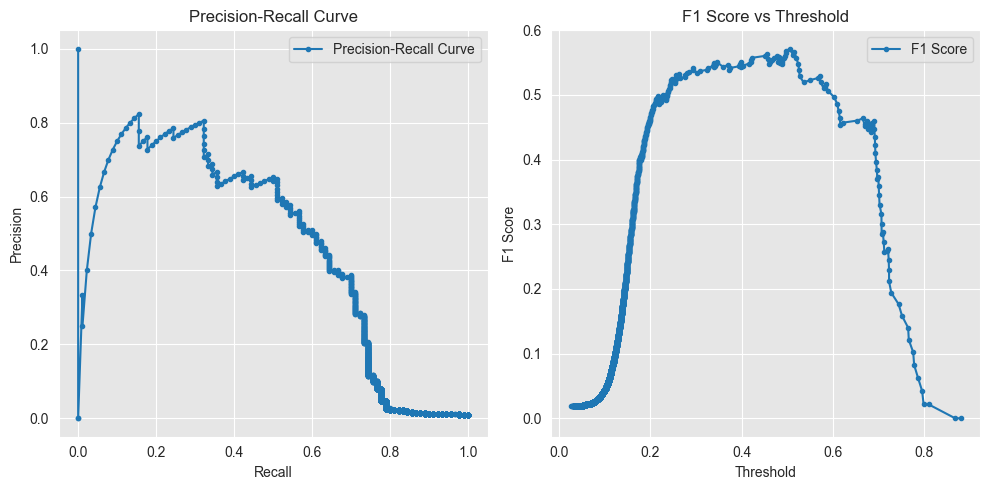

In [66]:
# plot PR Curve and 
plt.figure(figsize=(10, 5))

# Plot Precision-Recall curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot F1 scores against thresholds
plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores[:-1], marker='.', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
# Classify using the optimal threshold--> any probability > optimal threshold is labelled '1' (fraud)
batch_data['predictions_label']=(batch_data['predictions'] >= optimal_threshold).astype(int)

In [68]:
# check the prediction labels for the first 10 fraudulent transactions
batch_data[batch_data['TX_FRAUD']==1][['CUSTOMER_ID', 'TX_FRAUD', 'predictions','predictions_label']].head(10)

,CUSTOMER_ID,TX_FRAUD,predictions,predictions_label
1035709,2773,1,0.603063,1
1035748,1981,1,0.247228,0
1035810,3895,1,0.702551,1
1035869,349,1,0.612686,1
1035996,4073,1,0.087832,0
1036002,4791,1,0.722628,1
1036023,2090,1,0.221434,0
1036438,2409,1,0.665373,1
1036491,1711,1,0.706667,1
1036577,4514,1,0.711669,1


In [69]:
# performances on batch data
batch_assessment = performance_assessment(batch_data, top_k_list=[100])
batch_assessment

,AUC ROC,Average precision,Card Precision@100
0,0.861,0.467,0.5


Our PCA model seems to do well on the batch data with CP@100 being 0.48, meaning that on average within the batch period, 48 compromised cards out of 100 most suspicious card were correctly identified by the prediction model. The number of compromised cards on that day, 2021-07-30 was 79.

In [70]:
batch_data.groupby('CUSTOMER_ID').max().TX_FRAUD.sum()

76

Therefore, about 61% of the compromised cards were correctly detected. Also, the AUC ROC is above 0.5 meaning it is performing better than a random classifier

#### - Log batch Inference results to MLflow was artifacts

In [71]:
# Log the Batch data as an artifact
mlflow.start_run(run_id=pca_run_id)

# Save predictions as a pickle file
output_file = f"{model_name}_batch_predictions.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(batch_data, f)

# Log the CSV file as an artifact in the current run
mlflow.log_artifact(output_file)

# Log batch Inference Performance metrics
mlflow.log_metric("batch_AUC_ROC", batch_assessment["AUC ROC"].values[0])
mlflow.log_metric("batch_Average_precision", batch_assessment["Average precision"].values[0])
mlflow.log_metric("batch_Card_Precision_100", batch_assessment['Card Precision@100'].values[0])

# End the run
mlflow.end_run()

### 4.5.2 Online Inference

Although batch inference can be scaled effectively, many models require real-time serving to handle numerous incoming requests efficiently, maintaining high throughput and low latency. We prefer online inference over batch inference for our application because it allows us to promptly categorize transactions as it is received or submitted, enabling the investigators to discover fraudulent transactions more rapidly. This minimizes the potential losses by preventing fraud before it completes.

In this section, we will

- Set up FastAPI for Model Serving
- Integrate MLflow model with FastAPI for real-time inference

#### - Set up FastAPI for Model Serving

In [72]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import nest_asyncio
import uvicorn
import logging


nest_asyncio.apply()  # Patch the event loop

# Define the FastAPI app
app = FastAPI(
    title="Credit Card Fraud Detector",
    description="Classify transactions as fraud (1) or not fraud (0).",
    version="0.1")

# Load the model
model_uri = f"runs:/{pca_run_id}/model"
model = mlflow.sklearn.load_model(model_uri)


# Define input data schema
class FraudDetectionInput(BaseModel):
    features: list
    
#Define

# Define the FastAPI app
app = FastAPI()

# Set up logging
logging.basicConfig(filename='model_logs.log', level=logging.INFO, 
                    format='%(asctime)s:%(levelname)s:%(message)s')

@app.post("/predict")
async def predict(input_data: FraudDetectionInput):
    try:
        features = np.array(input_data.features).reshape(1, -1)
        prediction_prob = model.predict_proba(features, method = 'linear')[:,1] 
        
        # assign label to prediction
        threshold = 0.1
        prediction_label= int(prediction_prob[0] >= threshold)
        
        # Log the input data, prediction, and probability
        logging.info(f"Data: {input_data}, Prediction: {int(prediction_label)}, Probability: {float(prediction_prob[0])}")

        
        return {"fraud_prediction_proba": prediction_prob[0],"fraud_prediction_label": prediction_label}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


@app.get("/")
async def read_root():
    return {"message": "Credit Card Fraud Detection Model is running!"}

# Run the FastAPI server
def run_app():
    uvicorn.run(app, host="0.0.0.0", port=8000)

import threading
threading.Thread(target=run_app).start()

INFO:     Started server process [44121]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:58889 - "POST /predict HTTP/1.1" 200 OK


In [73]:
# get a set of transactions for online inference
online_inference_start_period = datetime.datetime.strptime("2021-07-26", "%Y-%m-%d")

online_data = transactions_df[(transactions_df.TX_DATETIME>=online_inference_start_period) &
                               (transactions_df.TX_DATETIME<online_inference_start_period+datetime.timedelta(days=1))].copy()

Since we are more interested in the fraudulent transactions, which occurs rarely in the dataset, we would create this function such that 80% of the time it chooses transactions that originally have been tagged as FRAUD. This data instance will be used for online inference.

In [74]:
def select_instance(df, target_column, target_value, target_ratio=0.5):
    """
    Function to randomly select an instance from a DataFrame, with a higher probability of selecting 
    from the target class.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_column (str): The name of the target column.
    target_value (any): The value in the target column to select 50% of the time.
    target_ratio (float): The probability of selecting from the target class (default is 0.5).
    
    Returns:
    pd.Series: A randomly selected instance from the DataFrame.
    """
    
    # Separate the DataFrame into the target class and the other class(es)
    df_target = df[df[target_column] == target_value]
    df_non_target = df[df[target_column] != target_value]
    
    # Decide whether to pick from the target class or the non-target class
    if np.random.rand() < target_ratio:
        # Select from the target class
        selected_instance = df_target.sample(n=1, random_state=None)
    else:
        # Select from the non-target class
        selected_instance = df_non_target.sample(n=1, random_state=None)
    
    return selected_instance.iloc[0]  # Return as a pandas Series

In [75]:
import requests

# select an instance
selected_instance = select_instance(online_data, target_column='TX_FRAUD', target_value=1, target_ratio=0.8)
print(f"True Label: {selected_instance['TX_FRAUD']}")

# Define input data
input_data = selected_instance[input_features].values.astype(float)

# Define the test data
test_data = {
    "features":input_data.tolist()  # Use the first instance of the test set
}

# Send a request to the FastAPI server
response = requests.post("http://localhost:8000/predict", json=test_data)

# Print the response from the server
print(response.json())

True Label: 1
{'fraud_prediction_proba': 0.21535378739243877, 'fraud_prediction_label': 1}


# END